# Prediction House Prices

## Importing libraries


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


## Importing data

In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [3]:
data = pd.concat((data_train.loc[:,'MSSubClass':'SaleCondition'],
                 data_test.loc[:,'MSSubClass':'SaleCondition']))

## Analyzing data

In [4]:
data_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [5]:
data_train.shape

(1460, 81)

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Analyzing SalePrice

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

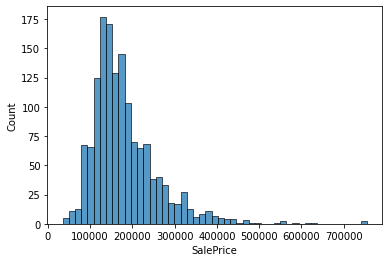

In [7]:
sns.histplot(data_train.SalePrice)

In [8]:
data_train.SalePrice.skew()

1.8828757597682129

### Corelation matrix

<AxesSubplot:>

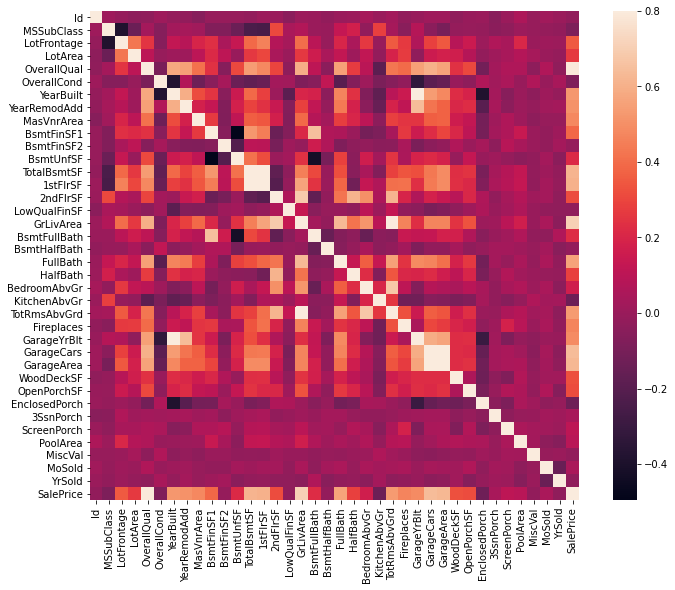

In [9]:
corrmat = data_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

### Finding 10 features, which mostly correlated with SalePrice 

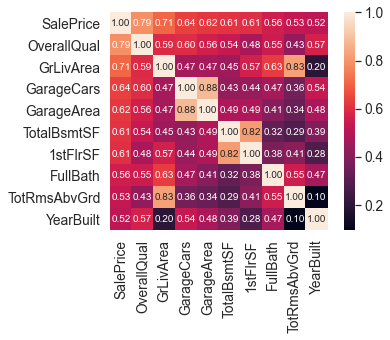

In [10]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

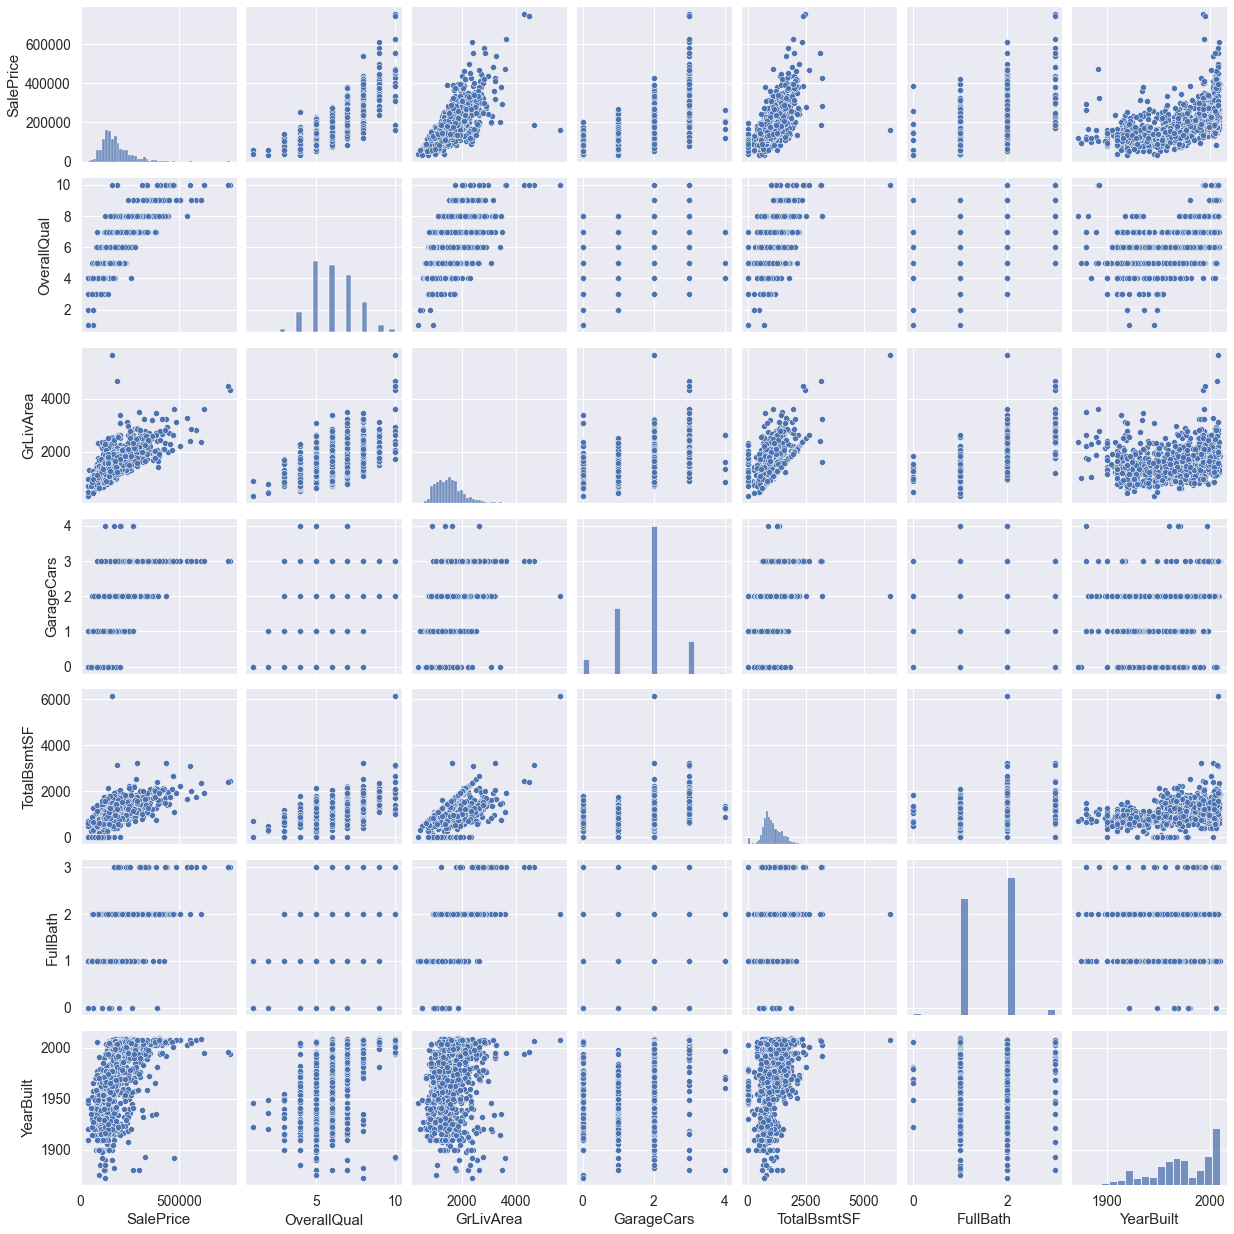

In [11]:
# We chooses OveallQual, GrLivArea, GarageCars (GarageCars and GarageArea are the same feature so can choose one), TotalBsmtSF (same as 1stFlrSF), FullBath and YearBuilt
most_features = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']  
sns.pairplot(data_train[most_features], height = 2.5)
plt.show()

## Cleaning data

In [12]:
#missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(30)

Total   Percent
PoolQC         2909  0.996574
MiscFeature    2814  0.964029
Alley          2721  0.932169
Fence          2348  0.804385
FireplaceQu    1420  0.486468
LotFrontage     486  0.166495
GarageYrBlt     159  0.054471
GarageFinish    159  0.054471
GarageQual      159  0.054471
GarageCond      159  0.054471
GarageType      157  0.053786
BsmtExposure     82  0.028092
BsmtCond         82  0.028092
BsmtQual         81  0.027749
BsmtFinType2     80  0.027407
BsmtFinType1     79  0.027064
MasVnrType       24  0.008222
MasVnrArea       23  0.007879
MSZoning          4  0.001370
Functional        2  0.000685
BsmtHalfBath      2  0.000685
BsmtFullBath      2  0.000685
Utilities         2  0.000685
SaleType          1  0.000343
BsmtFinSF1        1  0.000343
KitchenQual       1  0.000343
GarageCars        1  0.000343
BsmtUnfSF         1  0.000343
TotalBsmtSF       1  0.000343
Exterior2nd       1  0.000343

In [13]:
data = data.drop((missing_data[missing_data['Total'] > 2]).index,1)


## Normalize data


### Log transformations

In [14]:
#log transform the target:
data_train["SalePrice"] = np.log1p(data_train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = data.dtypes[data.dtypes != "object"].index

skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

data[skewed_feats] = np.log1p(data[skewed_feats])

## Dummy variables

In [15]:
data = pd.get_dummies(data)

## Fill N/A in all data

In [16]:
data = data.fillna(data.mean())

## Machine Learning


### Call X, y

In [17]:
X_train = data[:data_train.shape[0]]
X_test = data[data_train.shape[0]:]
y = data_train.SalePrice

### Import sklearn libraries and function for testing rmse

In [18]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

### Ridge

In [19]:
model_ridge = Ridge()

In [20]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

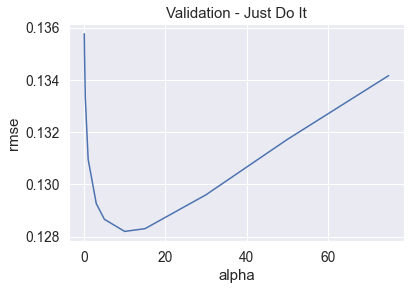

In [21]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [22]:
cv_ridge.min()

0.12819786167830663

In [23]:
### Lasso

In [24]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [25]:
rmse_cv(model_lasso).mean()

0.1255198920215072

We choose Lasso because of his rmse less than Ridge

### Use one more tool XGB


In [26]:
import xgboost as xgb

In [27]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=360, n_jobs=6, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Prediction

In [28]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

### Summary prediction with coefficients


In [29]:
preds = 0.65*lasso_preds + 0.35*xgb_preds

## Import results to CSV file

In [30]:
solution = pd.DataFrame({"id":data_test.Id, "SalePrice":preds})
solution.to_csv("my_house_predict.csv", index = False)